## TOPIC MODELING


In [1]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, TfidfModel
from gensim import similarities
import os
from gensim.corpora import MmCorpus, Dictionary
import pyLDAvis
import pyLDAvis.gensim
import numpy as np
from gensim.models.word2vec import LineSentence
from gensim.models.ldamulticore import LdaMulticore
import warnings

C:\Users\bbarsness\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
data_directory = 'staging'
trigram_dictionary_filepath = os.path.join(data_directory,'trigram_dict_all.dict')

trigram_bow_filepath = os.path.join(data_directory,'trigram_bow_corpus_all.mm')

In [3]:
# loading our corpus and dictionary
try:
    # load the finished dictionary from disk
    trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)
except FileNotFoundError as e:
    raise ValueError("SKIP: Please download the Corpus/news_dictionary dataset.")
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)
# it's very important that your corpus is saved in order of your time-slices!


## TFI-DF Model

In [4]:
tfidf = TfidfModel(trigram_bow_corpus)
corpus_tfidf = tfidf[trigram_bow_corpus]

In [6]:
# STEP 3 : Create similarity matrix of all files
print("STEP 3 : Create similarity matrix of all files")
print('-'*10)
index = similarities.MatrixSimilarity(tfidf[trigram_bow_corpus])
print("We compute similarities from the TF-IDF corpus : %s"%type(index))
index.save(os.path.join(data_directory,'tfidf.index'))
index = similarities.MatrixSimilarity.load(os.path.join(data_directory,'tfidf.index'))

sims = index[corpus_tfidf]
print("We get a similarity matrix for all documents in the corpus %s"% type(sims))
print 
#print("Done in %.3fs"%(time()-t0))
sims

STEP 3 : Create similarity matrix of all files
----------
We compute similarities from the TF-IDF corpus : <class 'gensim.similarities.docsim.MatrixSimilarity'>
We get a similarity matrix for all documents in the corpus <class 'numpy.ndarray'>


array([[0.99999994, 0.10005258, 0.02636601, ..., 0.05520397, 0.23677723,
        0.03330572],
       [0.10005258, 1.0000001 , 0.04414055, ..., 0.07662785, 0.10962072,
        0.04946405],
       [0.02636601, 0.04414055, 0.99999976, ..., 0.06537011, 0.03306145,
        0.02386713],
       ...,
       [0.05520397, 0.07662785, 0.06537011, ..., 1.        , 0.08451095,
        0.03104855],
       [0.23677723, 0.10962072, 0.03306145, ..., 0.08451095, 1.0000002 ,
        0.03593027],
       [0.03330572, 0.04946405, 0.02386713, ..., 0.03104855, 0.03593027,
        1.        ]], dtype=float32)

## DTM Model

In [13]:
%%time

from gensim.models.wrappers import DtmModel

#path_to_dtm_binary = "./dtm_self_compiled"
path_to_dtm_binary = "dtm-win64.exe"

dtm = DtmModel(
    path_to_dtm_binary, corpus=trigram_bow_corpus, 
    id2word=trigram_dictionary, 
    time_slices=[40,49],
    num_topics=5,
    initialize_lda=True
    #time_slices=[1] * len(trigram_bow_corpus)
)

OSError: [WinError 216] This version of %1 is not compatible with the version of Windows you're running. Check your computer's system information and then contact the software publisher

In [62]:
topics = dtm.show_topic(topicid=1, time=1, num_words=10)
topics

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


[(0.029667688394479499, 'resident'),
 (0.01405931589025973, 'nursing_home'),
 (0.012692347114786479, 'facility'),
 (0.012518649029147986, 'care'),
 (0.0094739817557837145, 'state'),
 (0.0079846956301450073, 'long_term_care'),
 (0.0070639389594181826, 'datum'),
 (0.0054653945764001777, 'rate'),
 (0.0052751716696835928, 'analysis'),
 (0.005157434154982531, '1998')]

In [63]:
#topics = dtm.show_topic(topicid=0, time=1, num_words=10)
dtm.show_topics(num_topics=5, times=1, num_words=5, log=False, formatted=False)


/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


[[(0.015150636981235472, 'care'),
  (0.013008590230610059, 'service'),
  (0.010708299283298875, 'need'),
  (0.0074394541577783857, 'intervention'),
  (0.0071898140482352865, 'quality')],
 [(0.028594613712500872, 'resident'),
  (0.013725872028908247, 'nursing_home'),
  (0.012554122641843191, 'facility'),
  (0.012474063806535041, 'care'),
  (0.0092354358327163873, 'state')],
 [(0.016214890122915496, 'age'),
  (0.0081516549368954652, 'old'),
  (0.0072846555342692817, 'group'),
  (0.0071606122392167352, 'survey'),
  (0.0055309040187708873, 'ageism')],
 [(0.022477133088814896, 'caregiver'),
  (0.0084332516621547105, 'family'),
  (0.0077891593617393758, 'child'),
  (0.0072945204799846446, 'care'),
  (0.0071259292025677894, 'parent')],
 [(0.013001788738669322, 'item'),
  (0.0099297029022976917, 'measure'),
  (0.0077809455530181556, 'sample'),
  (0.0076806123509558944, 'score'),
  (0.0068114428173521703, 'depression')]]

In [64]:
dtm.print_topics(num_topics=5, times=1, num_words=10)

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/dtmmodel.py:529: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


['0.015*care + 0.013*service + 0.011*need + 0.007*intervention + 0.007*quality + 0.007*program + 0.006*research + 0.006*information + 0.006*group + 0.006*ltc',
 '0.029*resident + 0.014*nursing_home + 0.013*facility + 0.012*care + 0.009*state + 0.008*long_term_care + 0.007*datum + 0.005*analysis + 0.005*rate + 0.005*1998',
 '0.016*age + 0.008*old + 0.007*group + 0.007*survey + 0.006*ageism + 0.005*participant + 0.005*work + 0.005*year + 0.004*number + 0.004*individual',
 '0.022*caregiver + 0.008*family + 0.008*child + 0.007*care + 0.007*parent + 0.006*group + 0.005*sample + 0.005*analysis + 0.005*experience + 0.004*level',
 '0.013*item + 0.010*measure + 0.008*sample + 0.008*score + 0.007*depression + 0.006*factor + 0.006*participant + 0.006*scale + 0.005*subject + 0.005*interview']

In [65]:
dtm.save(os.path.join(data_directory,'dtm_model'))
#dtm_model = DtmModel.load('dtm_model')

In [66]:
len(trigram_bow_corpus)

89

In [67]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = dtm.dtm_vis(time=0, corpus=trigram_bow_corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


## LSI Model


In [68]:
lsimodel = LsiModel(corpus=trigram_bow_corpus, num_topics=10, id2word=trigram_dictionary)

In [69]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.258*"care" + 0.241*"resident" + 0.240*"caregiver" + 0.161*"group" + 0.156*"nursing_home" + 0.122*"age" + 0.121*"measure" + 0.115*"analysis" + 0.114*"datum" + 0.114*"service"'),
 (1,
  '-0.509*"caregiver" + 0.466*"resident" + 0.267*"care" + 0.233*"nursing_home" + 0.217*"facility" + 0.185*"quality" + 0.125*"staff" + -0.097*"sample" + 0.094*"long_term_care" + -0.090*"depression"'),
 (2,
  '0.588*"caregiver" + 0.338*"resident" + -0.219*"age" + 0.185*"intervention" + 0.147*"care" + 0.141*"nursing_home" + -0.136*"old" + -0.114*"child" + -0.103*"respondent" + 0.097*"staff"'),
 (3,
  '-0.307*"long_term_care" + 0.296*"resident" + -0.235*"service" + -0.221*"care" + -0.211*"caregiver" + 0.196*"item" + -0.175*"ltc" + -0.164*"story" + -0.142*"issue" + 0.141*"measure"'),
 (4,
  '-0.408*"child" + -0.404*"parent" + 0.287*"item" + 0.194*"subject" + -0.173*"retirement" + -0.158*"contact" + 0.124*"score" + -0.112*"visit" + -0.107*"care" + -0.106*"contact_with"')]

## HDP Model

In [70]:
hdpmodel = HdpModel(corpus=trigram_bow_corpus, id2word=trigram_dictionary)

In [71]:
hdpmodel.show_topics()

[(0,
  '0.008*caregiver + 0.008*group + 0.007*resident + 0.007*intervention + 0.005*care + 0.005*service + 0.004*analysis + 0.004*measure + 0.004*datum + 0.004*age + 0.003*sample + 0.003*outcome + 0.003*family + 0.003*life + 0.003*old + 0.003*nursing_home + 0.003*et_al + 0.003*difference + 0.003*variable + 0.003*need'),
 (1,
  '0.010*quality + 0.010*nursing_home + 0.008*care + 0.008*pain + 0.008*resident + 0.006*ltc + 0.005*medication + 0.005*life + 0.004*facility + 0.004*good + 0.004*outcome + 0.004*measure + 0.004*need + 0.003*cost + 0.003*administrator + 0.003*research + 0.003*service + 0.003*examine + 0.003*effect + 0.003*increase'),
 (2,
  '0.015*long_term_care + 0.008*care + 0.007*story + 0.007*service + 0.006*nursing_home + 0.005*care_receiver + 0.005*issue + 0.005*1998 + 0.005*person + 0.004*coverage + 0.004*caregiver + 0.004*group + 0.004*medicaid + 0.004*individual + 0.004*response + 0.004*medium + 0.004*datum + 0.004*home + 0.003*question + 0.003*number'),
 (3,
  '0.021*resi

## LDA Model


In [72]:
ldamodel = LdaModel(corpus=trigram_bow_corpus, num_topics=10, id2word=trigram_dictionary)

In [73]:
ldamodel.show_topics()

[(0,
  '0.006*"care" + 0.006*"resident" + 0.006*"age" + 0.005*"state" + 0.005*"group" + 0.004*"item" + 0.004*"caregiver" + 0.004*"information" + 0.004*"time" + 0.004*"research"'),
 (1,
  '0.010*"care" + 0.007*"nursing_home" + 0.006*"caregiver" + 0.004*"age" + 0.004*"resident" + 0.004*"research" + 0.004*"measure" + 0.004*"factor" + 0.004*"group" + 0.004*"datum"'),
 (2,
  '0.010*"care" + 0.009*"resident" + 0.006*"group" + 0.006*"service" + 0.005*"participant" + 0.005*"measure" + 0.005*"item" + 0.004*"caregiver" + 0.004*"age" + 0.004*"sample"'),
 (3,
  '0.008*"resident" + 0.007*"care" + 0.006*"age" + 0.006*"state" + 0.005*"datum" + 0.005*"need" + 0.004*"measure" + 0.004*"facility" + 0.004*"research" + 0.004*"quality"'),
 (4,
  '0.006*"measure" + 0.005*"care" + 0.005*"age" + 0.005*"caregiver" + 0.005*"resident" + 0.005*"item" + 0.005*"need" + 0.005*"sample" + 0.004*"datum" + 0.004*"information"'),
 (5,
  '0.009*"caregiver" + 0.008*"care" + 0.006*"resident" + 0.006*"group" + 0.004*"service"

In [74]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, trigram_bow_corpus, trigram_dictionary)

/Users/bcbarsness/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      26.281008        1       1 -0.003384  0.005831
5      13.970041        1       2 -0.001471 -0.003308
0      13.304699        1       3  0.002966  0.003184
9      12.911619        1       4 -0.006212 -0.001608
8      10.167870        1       5  0.010283 -0.005821
6       8.946396        1       6 -0.007700 -0.003297
3       5.667856        1       7  0.003567  0.007913
7       5.482610        1       8 -0.001562 -0.000323
1       2.638338        1       9  0.000639 -0.003828
4       0.629556        1      10  0.002875  0.001257, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
187   Default  1455.000000            care  1455.000000  30.0000  30.0000
190   Default  1076.000000       caregiver  1076.000000  29.0000  29.0000
112   Default   819.000000             age   819.000000  28.0000  28.0000
578   Default   798.000000         measure   798.000000  27.0000  27.0000
1253  Default  1193.000000        resident  1193.000000  26.0000  26.0000
612   Default   655.000000            need   655.000000  25.0000  25.0000
1209  Default   661.000000    nursing_home   661.000000  24.0000  24.0000
524   Default   680.000000            item   680.000000  23.0000  23.0000
280   Default   696.000000           datum   696.000000  22.0000  22.0000
785   Default   668.000000          sample   668.000000  21.0000  21.0000
769   Default   600.000000        research   600.000000  20.0000  20.0000
619   Default   536.000000          number   536.000000  19.0000  19.0000
1155  Default   426.000000     information   426.000000  18.0000  18.0000
1278  Default   577.000000           state   577.000000  17.0000  17.0000
806   Default   743.000000         service   743.000000  16.0000  16.0000
1182  Default   400.000000  long_term_care   400.000000  15.0000  15.0000
125   Default   697.000000        analysis   697.000000  14.0000  14.0000
445   Default   987.000000           group   987.000000  13.0000  13.0000
1210  Default   487.000000             old   487.000000  12.0000  12.0000
398   Default   477.000000          family   477.000000  11.0000  11.0000
1111  Default   468.000000        facility   468.000000  10.0000  10.0000
396   Default   522.000000          factor   522.000000   9.0000   9.0000
533   Default   561.000000           level   561.000000   8.0000   8.0000
936   Default   438.000000        variable   438.000000   7.0000   7.0000
497   Default   506.000000      individual   506.000000   6.0000   6.0000
966   Default   475.000000            year   475.000000   5.0000   5.0000
1135  Default   491.000000          health   491.000000   4.0000   4.0000
707   Default   381.000000         program   381.000000   3.0000   3.0000
1152  Default   526.000000        increase   526.000000   2.0000   2.0000
772   Default   405.000000      respondent   405.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
612   Topic10     5.334192            need   655.383118   0.2568  -5.3643
785   Topic10     5.329629          sample   668.378662   0.2363  -5.3652
918   Topic10     2.698613            type   314.733826   0.3089  -6.0457
772   Topic10     3.330237      respondent   405.208374   0.2666  -5.8354
721   Topic10     1.665808           range   180.666367   0.3816  -6.5281
313   Topic10     2.447479       different   288.691956   0.2976  -6.1434
1210  Topic10     3.770535             old   487.876129   0.2051  -5.7112
112   Topic10     5.711916             age   819.705688   0.1015  -5.2959
661   Topic10     2.666054          person   325.683228   0.2626  -6.0578
497   Topic10     3.814027      individual   506.065033   0.1799  -5.6998
619   Topic10     3.989630          number   536.361267   0.1668  -5.6547
490   Topic10     2.179016          income   257.2114

In [75]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [76]:
trigram_articles_filepath = os.path.join(data_directory,'trigram_transformed_articles_all.txt')
trigram_articles = LineSentence(trigram_articles_filepath)

In [77]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=trigram_articles, dictionary=trigram_dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=trigram_articles, dictionary=trigram_dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=trigram_articles, dictionary=trigram_dictionary, window_size=10).get_coherence()

In [78]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

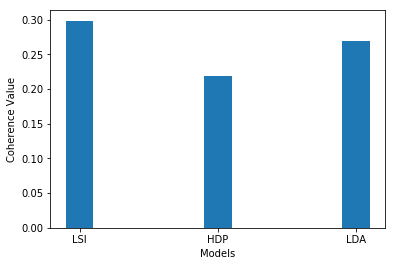

In [79]:
import matplotlib.pyplot as plt
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

In [80]:
lda_model_filepath = os.path.join(data_directory, 'lda_model_all')

In [81]:
%%time

# this is a bit time consuming - make the if statement True
# if you want to train the LDA model yourself.
if True:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaMulticore(trigram_bow_corpus,
                           num_topics=5,
                           id2word=trigram_dictionary,
                           workers=3)
    
    lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaMulticore.load(lda_model_filepath)

CPU times: user 839 ms, sys: 85.1 ms, total: 924 ms
Wall time: 1.03 s


In [82]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=25):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [83]:
explore_topic(topic_number=2)

term                 frequency

caregiver            0.009
resident             0.008
care                 0.008
service              0.005
nursing_home         0.005
group                0.005
measure              0.005
datum                0.004
factor               0.004
age                  0.004
need                 0.004
sample               0.004
analysis             0.004
change               0.004
research             0.004
facility             0.003
level                0.003
score                0.003
time                 0.003
item                 0.003
information          0.003
state                0.003
depression           0.003
model                0.003
quality              0.003
